# Survival Analysis Tutorial Part 1

[I. What is time-censored data?](#I.-What-is-time-censored-data?) <br>
[II. Single event survival analysis with Kaplan-Meier](#II.-Single-event-survival-analysis-with-Kaplan-Meier) <br>
[III. Calibration using the integrated brier score (IBS)](#III.-Calibration-using-the-integrated-brier-score-(IBS)) <br>
[IV. Predictive Survival Analysis](#IV.-Predictive-survival-analysis) <br>
[V. Competing risks modeling with Aalen-Johanson](#V.-Competing-risks-modeling-with-Aalen-Johanson) <br>
[VI. Cumulative incidence function (CIF) using our GradientBoostedCIF](#VI.-Cumulative-incidence-function-(CIF)-using-our-GradientBoostedCIF) <br>

## I. What is time-censored data?

### I.1 Censoring

Survival analysis is a time-to-event regression problem, with censored data. We call censored all individuals that didn't experience the event during the range of the observation window.

In our setting, we're mostly interested in right-censored data, meaning we that the event of interest did not occur before the end of the observation period (typically the time of collection of the dataset):

<figure>
<img src="censoring.png" style="width:80%">
<figcaption align = "center"> <i>image credit: scikit-survival</i> </figcaption>
</figure>

Individuals can join the study at the same or different times, and the study may or may not be ended by the time of observation.

Survival analysis techniques have wide applications:

- In the **medical** landscape, events can consist in patients dying of cancer, or on the contrary recovering from some disease.
- In **predictive maintenance**, events can model machine failure.
- In **insurance**, we are interesting in modeling the time to next claim for a portfolio of insurance contracts.
- In **marketing**, we can consider user churning as events, or we could focus on users becoming premium.


As we will see, for all those application, it is not possible to directly train a machine learning based regression model on such  **right-censored** time-to-event target since we only have a lower bound on the true time to event for some data points. **Naively removing such points from the data would cause the model predictions to be biased**.

### I.2 Our target `y`

For each individual $i\in[1, N]$, our survival analysis target $y_i$ is comprised of two elements:

- The event $\delta_i\in\{0, 1\}$, where $0$ is censoring and $1$ is experiencing the event.
- The censored time-to-event $d_i=min(t_{i}, c_i) > 0$, that is the minimum between the date of the experienced event $t_i$ and the censoring date $c_i$. In a real-world setting, we don't have direct access to $t_i$ when $\delta_i=0$.

Here is how we represent our target:

In [1]:
import pandas as pd
import numpy as np

truck_failure_events = pd.read_parquet("truck_failure_10k_any_event.parquet")
truck_failure_events

event     duration
0      True   980.394661
1      True  1207.870100
2     False   125.000000
3      True    96.839004
4      True    88.077852
...     ...          ...
9995   True     0.435731
9996   True   492.591211
9997   True   847.951259
9998   True    25.551167
9999  False    23.000000

[10000 rows x 2 columns]

In this exemple, we study the accident of truck-driver pairs. Censored pairs (when event is 0 or False) haven't had a mechanical failure or an accident during the study.

### I.3 Why is it a problem to train time-to-event regression models?

Without survival analysis, we have two options when confronting censored data:
- We ignore them, by only keeping events that happened and performing naive regression on them.
- We consider that all censored events happen at the end of our observation window.

**Both approaches are wrong and lead to biased results.**

Let's compute the average duration yielded by both approaches on our truck dataset. We will compare them to the mean of the ground-truth event time $T$, that we would obtained with an infinite observation window. 

Note that we have access to the random variable $T$ because we generated this synthetic dataset. With real-world data, you only have access to $Y = \min(T, C)$, where $C$ is a random variable representing the censoring time.

In [2]:
naive_stats_1 = (
    truck_failure_events.query("event == True")["duration"]
    .apply(["mean", "median"])
)
print(
    f"Biased method 1 - mean: {naive_stats_1['mean']:.2f} days, "
    f"median: {naive_stats_1['median']:.2f} days"
)

Biased method 1 - mean: 633.28 days, median: 426.36 days


In [3]:
max_duration = truck_failure_events["duration"].max()
naive_stats_2 = (
    pd.Series(
        np.where(
            truck_failure_events["event"],
            truck_failure_events["duration"],
            max_duration,
        )
    )
    .apply(["mean", "median"])
)
print(
    f"Biased method 2 - mean: {naive_stats_2['mean']:.2f} days, "
    f"median: {naive_stats_2['median']:.2f} days"
)

Biased method 2 - mean: 1282.71 days, median: 903.33 days


Neither naive methods can estimate the true mean and median failure times. In our case, the data comes from a simple truck fleed model and we have access to the uncensored times (we can wait as long as we want to extend the observation period as needed to have all truck fail).

Let's have a look at the true mean and median time-to-failure:

In [4]:
truck_failure_events_uncensored = pd.read_parquet("truck_failure_10k_any_event_uncensored.parquet")

In [5]:
true_stats = truck_failure_events_uncensored["duration"].apply(["mean", "median"])
print(
    f"Ground truth - mean: {true_stats['mean']:.2f} days, "
    f"median: {true_stats['median']:.2f} days"
)

Ground truth - mean: 865.17 days, median: 731.92 days


We see that none of neither of the naive methods gives a good estimate of the ground truth.

If we have access to covariates $X$ (also known as input features in machine learning), a naive regression method would try to estimate $\mathbb{E}[T|X]$, where $X$ are our covariates, but we only have access to $Y = \min(T, C)$ where $T$ is the true time to failure and $C$ is the censoring duration.


Here is structured outline of the estimators we will introduce in this tutorial:



|                                          | Unconditional: only `y`, no `X`        | Conditional: `y` given  `X`                     |
|------------------------------------------|----------------------------------------|-------------------------------------------------|
| Suvival Analysis (1 event type)          | Kaplan-Meier                           | Cox PH, Survival Forests, Gradient Boosting CIF |
| Competing Risks Analysis (k event types) | Aalen-Johansen                         | Gradient Boosting CIF                           |


## II. Single event survival analysis with Kaplan Meier

We now introduce the survival analysis approach to the problem of estimating the time-to-event from censored data. For now, we ignore any information from $X$ and focus on $y$ only.

Here our quantity of interest is the survival probability:

$$S(t)=P(T > t)$$ 

This represents the probability that an event doesn't occur at or before some given time $t$, i.e. that it happens at some time $T > t$.

The most commonly used method to estimate this function is the **Kaplan Meier** estimator. It gives us an **unbiased estimate of the survival probability**.

$$\hat{S}(t)=\prod_{i: t_i\leq t} (1 - \frac{d_i}{n_i})$$

Where:

- $t_i$ is the time of event for individual $i$ that experienced the event,
- $d_i$ is the number of individuals having experienced the event at $t_i$,
- $n_i$ are the remaining individuals at risk at $t_i$.

Note that **individuals that were censored before $t_i$ are no longer considered at risk at $t_i$**.

Note that, contrary to machine learning regressors, this estimator is **unconditional**: it only extracts information from $y$ only, and cannot model information about each individual typically provided in a feature matrix $X$.

In real-world application, we aim at estimating $\mathbb{E}[T]$ or $Q_{50\%}[T]$. The latter quantity represents the median survival duration i.e. the duration before 50% of our population at risk experiment the event. We can also be interested in estimating the survival probability after some reference time $P(T > t_{ref})$, e.g. a random clinical trial estimating the capacity of a drug to improve the survival probability after 6 months.

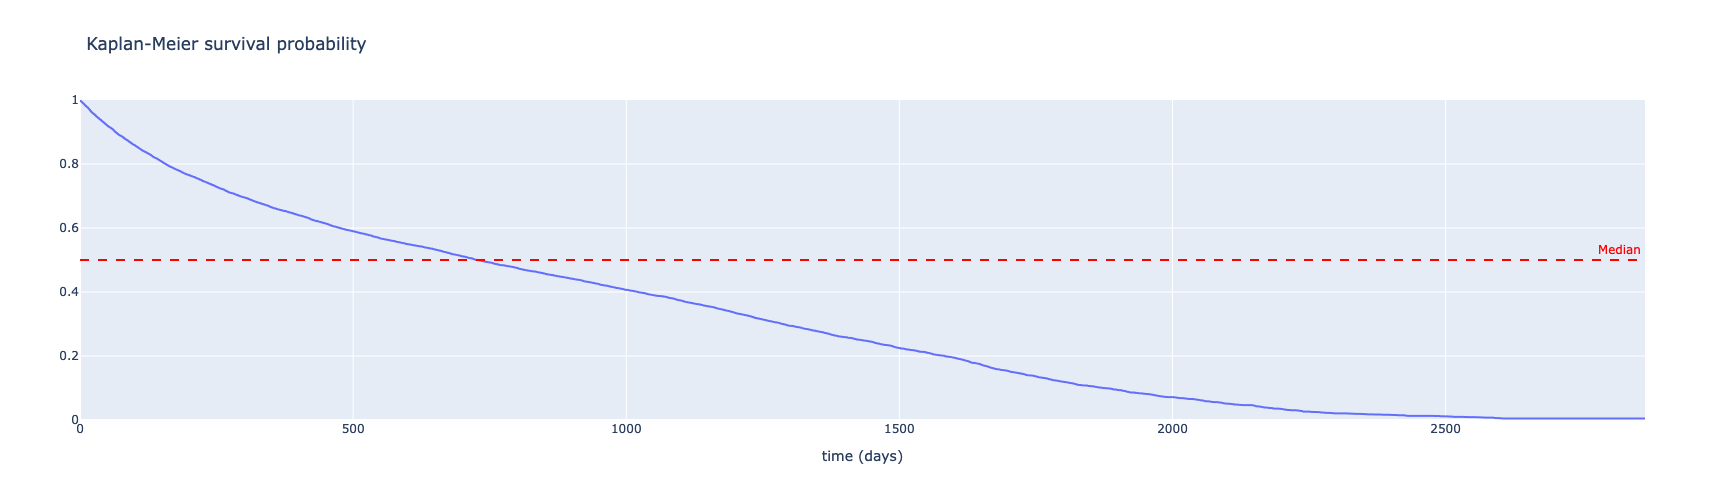

In [6]:
import plotly.express as px
from sksurv.nonparametric import kaplan_meier_estimator


times, survival_probs = kaplan_meier_estimator(
    truck_failure_events["event"], truck_failure_events["duration"]
)

km_proba = pd.DataFrame(dict(time=times, survival_probs=survival_probs))
fig = px.line(
    km_proba,
    x="time",
    y="survival_probs",
    title="Kaplan-Meier survival probability",
)
fig.add_hline(
    y=0.50,
    annotation_text="Median",
    line_dash="dash",
    line_color="red",
    annotation_font_color="red",
)

fig.update_layout(
    height=500,
    width=800,
    xaxis_title="time (days)",
    yaxis_title="$\hat{S}(t)$",
    yaxis_range=[0, 1],
)

We can read the median time to event directly from this curve, in this case close to 1020 days.
Note that since we have censored data, $S(t)$ doesn't reach 0 within our observation window and we have residuals of 30%.

***Exercice*** <br>
Based on `times` and `survival_probs`, estimate the median survival time.
*Hint: Use `np.searchsorted`*.

In [7]:
def get_median_survival_probs(times, survival_probs):
    """Get the closest time to a survival proba of 50%.
    """
    ### Your code here
    median_survival_probs_time = 0
    ###
    return median_survival_probs_time












get_median_survival_probs(times, survival_probs)

0

In [8]:
### Solution

def get_median_survival_probs(times, survival_probs):
    """Get the closest time to a survival proba of 50%."""
    # Search sorted needs an ascending ordered array.
    sorted_survival_probs = survival_probs[::-1]
    median_idx = np.searchsorted(sorted_survival_probs, 0.50)
    median_survival_probs_time = times[-median_idx]
    return median_survival_probs_time

get_median_survival_probs(times, survival_probs)

728.7515457889472

This should be an unbiased estimate of the median uncensored duration:

In [9]:
truck_failure_events_uncensored["duration"].median()

731.9224508119453

We can enrich our analysis by introducing covariates, that are statistically associated to the events and durations.

In [10]:
truck_failure_features = pd.read_parquet("truck_failure_10k_features.parquet")
truck_failure_features

driver_skill    brand truck_model  usage_rate
0         0.639051   Cheapz          C3    0.796655
1         0.772151  Robusta          RA    0.497168
2         0.682211  Robusta          RB    0.552889
3         0.635907   Cheapz          C3    0.307816
4         0.538924   Cheapz          C1    0.752634
...            ...      ...         ...         ...
9995      0.640357  Robusta          RA    0.757384
9996      0.517721  Robusta          RB    0.748577
9997      0.806744   Cheapz          C2    0.642618
9998      0.219030   Cheapz          C1    0.633277
9999      0.850860   Cheapz          C2    0.450610

[10000 rows x 4 columns]

In [11]:
truck_failure_features_and_events = pd.concat(
    [truck_failure_features, truck_failure_events], axis="columns"
)
truck_failure_features_and_events

driver_skill    brand truck_model  usage_rate  event     duration
0         0.639051   Cheapz          C3    0.796655   True   980.394661
1         0.772151  Robusta          RA    0.497168   True  1207.870100
2         0.682211  Robusta          RB    0.552889  False   125.000000
3         0.635907   Cheapz          C3    0.307816   True    96.839004
4         0.538924   Cheapz          C1    0.752634   True    88.077852
...            ...      ...         ...         ...    ...          ...
9995      0.640357  Robusta          RA    0.757384   True     0.435731
9996      0.517721  Robusta          RB    0.748577   True   492.591211
9997      0.806744   Cheapz          C2    0.642618   True   847.951259
9998      0.219030   Cheapz          C1    0.633277   True    25.551167
9999      0.850860   Cheapz          C2    0.450610  False    23.000000

[10000 rows x 6 columns]

For exemple, let's use Kaplan Meier to get a sense of the impact of the **brand**, by stratifying on this variable.

***Exercice***

Plot the stratified Kaplan Meier of the brand, i.e. for each different brand:
1. Filter the dataset on this brand using pandas, for instance using the `.query` method of the dataframe;
2. Estimate the survival curve with Kaplan Meier on each brand subset;
3. Plot the survival curve for each subset.

What are the limits of this method?

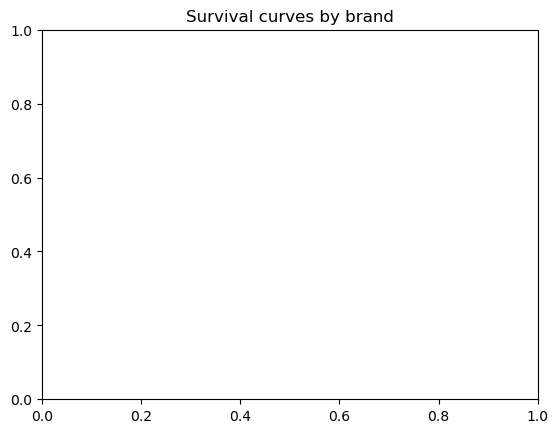

In [12]:
import matplotlib.pyplot as plt


def plot_brands_km(df):
    brands = df["brand"].unique()
    fig_data = []
    for brand in brands:
        # TODO: replace the following by your code here:
        pass

    plt.title("Survival curves by brand")

    
plot_brands_km(truck_failure_features_and_events)

**Solution**: click below to expand the cell:

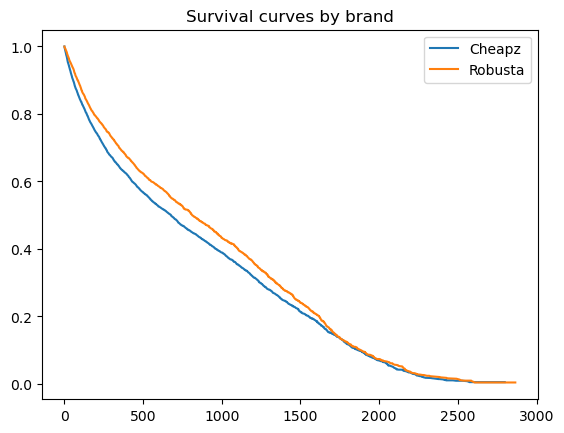

In [13]:
import matplotlib.pyplot as plt


def plot_brands_km(df):
    brands = df["brand"].unique()
    fig_data = []
    for brand in brands:
        df_brand = df.query("brand == @brand")
        x, y = kaplan_meier_estimator(df_brand["event"], df_brand["duration"])
        plt.plot(x, y, label=brand)

    plt.legend()
    plt.title("Survival curves by brand")
    
plot_brands_km(truck_failure_features_and_events)

We can observe that drivers of "Cheapz" trucks seem to experiment a higher number of failures in the early days but then the cumulative number of failures for each group seem to become comparable. Very truck seem to operate after 2500 days (~7 years) without having experienced any failure.

The stratified KM method is nice to compare two groups but quickly becomes impracticable as the number of covariate groups grow. We need estimator that can handle covariates.

Let's now attempt to quantify how a survival curve estimated on a training set performs on a test set.

## III. Survival model evaluation using the Integrated Brier Score (IBS) and the Concordance Index (C-index)

The Brier score and the C-index are measures that assess the quality of predicted survival curve on a sample of data. The Brier score is a proper scoring rule, meaning that a model has minimal Brier score if and only if it correctly estimates the true survival probabilities induced by the underlying data generating process. In that respect the **Brier score** assesses both the **calibration** and the **ranking power** of a survival probability estimator.

On the other hand, the **C-index** only assesses the **ranking power**: it is invariant to a monotonic transform of the survival probabilities. It only focus on the ability of a predictive survival model to identify which individual is likely to fail first out of any pair of two individuals.



It is comprised between 0 and 1 (lower is better).
It answers the question "how close to the real probabilities are our estimates?".




<details><summary>Mathematical formulation</summary>
    
$$\mathrm{BS}^c(t) = \frac{1}{n} \sum_{i=1}^n I(d_i \leq t \land \delta_i = 1)
        \frac{(0 - \hat{S}(t | \mathbf{x}_i))^2}{\hat{G}(d_i)} + I(d_i > t)
        \frac{(1 - \hat{S}(t | \mathbf{x}_i))^2}{\hat{G}(t)}$$
    
In the survival analysis context, the Brier Score can be seen as the Mean Squared Error (MSE) between our probability $\hat{S}(t)$ and our target label $\delta_i \in {0, 1}$, weighted by the inverse probability of censoring $\frac{1}{\hat{G}(t)}$.
- When no event or censoring has happened at $t$ yet, i.e. $I(d_i > t)$, we penalize a low probability of survival with $(1 - \hat{S}(t|\mathbf{x}_i))^2$.
- Conversely, when an individual has experienced an event before $t$, i.e. $I(d_i \leq t \land \delta_i = 1)$, we penalize a high probability of survival with $(0 - \hat{S}(t|\mathbf{x}_i))^2$.
    
<figure>
<img src="BrierScore.svg" style="width:80%">
</figure>
    
</details>

In [14]:
from sklearn.model_selection import train_test_split


def train_test_split_within(X, y, idx, **kwargs):
    """Ensure that test data durations are within train data durations."""
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx, **kwargs)
    mask_duration_inliers = y_test["duration"] < y_train["duration"].max()
    X_test = X_test[mask_duration_inliers]
    y_test = y_test[mask_duration_inliers]
    idx_test = idx_test[mask_duration_inliers]
    return X_train, X_test, y_train, y_test, idx_train, idx_test


X = truck_failure_features
y = truck_failure_events

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split_within(
    X, y, np.arange(X.shape[0]), test_size=0.5, random_state=0
)

In [15]:
from scipy.interpolate import interp1d

km_times, km_survival_probs = kaplan_meier_estimator(
    y_train["event"], y_train["duration"]
)

km_predict = interp1d(
    km_times,
    km_survival_probs,
    kind="previous",
    bounds_error=False,
    fill_value="extrapolate",
)

In [16]:
from sksurv.metrics import brier_score

def make_test_time_grid(duration):
    """Bound times to the range of duration."""
    # Some survival models can fail to predict near the boundary of the
    # range of durations observed on the training set.
    span = duration.max() - duration.min()
    start = duration.min() + span / 20
    stop = duration.max() - span / 20
    return np.linspace(start, stop, num=100)

time_grid = make_test_time_grid(y_test["duration"])

# KM is a constant predictor: it always estimate the same survival
# curve for any individual in the training and test sets as it does
#not depend on features values of the X_train and X_test matrices.
km_curve = km_predict(time_grid)
y_pred_km_train = np.vstack([km_curve] * y_train.shape[0])
y_pred_km_test = np.vstack([km_curve] * y_test.shape[0])


def as_sksurv_recarray(y_frame):
    """Return scikit-survival's specific target format."""
    y_recarray = np.empty(
        shape=y_frame.shape[0],
        dtype=[("event", np.bool_), ("duration", np.float64)],
    )
    y_recarray["event"] = y_frame["event"]
    y_recarray["duration"] = y_frame["duration"]
    return y_recarray


_, km_brier_scores = brier_score(
    survival_train=as_sksurv_recarray(y_train),
    survival_test=as_sksurv_recarray(y_test),
    estimate=y_pred_km_test,
    times=time_grid,
)

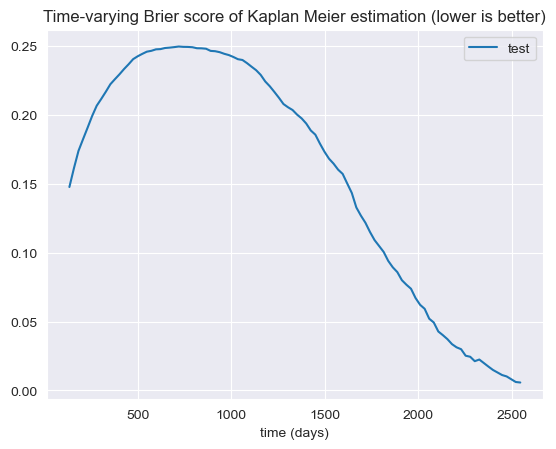

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")

plt.plot(time_grid, km_brier_scores, label="test");
plt.title("Time-varying Brier score of Kaplan Meier estimation (lower is better)");
plt.legend()
plt.xlabel("time (days)");

Additionnaly, we compute the Integrated Brier Score (IBS) which we will use to rank estimators:
$$IBS = \frac{1}{t_{max} - t_{min}}\int^{t_{max}}_{t_{min}} BS(t) dt$$

In [18]:
from sksurv.metrics import integrated_brier_score

km_ibs_test = integrated_brier_score(
    survival_train=as_sksurv_recarray(y_train),
    survival_test=as_sksurv_recarray(y_test),
    estimate=y_pred_km_test,
    times=time_grid,
)
print(f"IBS of Kaplan-Meier estimator on test set: {km_ibs_test:.3f}")

IBS of Kaplan-Meier estimator on test set: 0.158


Since the KM estimator always predicts the same constant survival curve for any samples in `X_train` or `X_test`, it has the same IBS on both subsets. Still, it's an interesting baseline because it's well calibrated among all the constant survival curve predictors.

For instance we could compare to a model that would predict a linear decrease of the survival probability over time and measure the IBS on the same test data. The KM-survival curve is hopefully better than such a dummy predictor:

In [19]:
linear_survival_curve = np.linspace(1.0, 0.0, time_grid.shape[0])
constant_linear_survival_curves = [linear_survival_curve] * y_test.shape[0]

linear_survival_ibs_test = integrated_brier_score(
    survival_train=as_sksurv_recarray(y_train),
    survival_test=as_sksurv_recarray(y_test),
    estimate=constant_linear_survival_curves,
    times=time_grid,
)
print(f"IBS of linear survival estimator on test set: {linear_survival_ibs_test:.3f}")

IBS of linear survival estimator on test set: 0.199


Finally, let's also introduce the concordance index (C-index). This metric evaluates the ranking (or discriminative) power of a model by comparing pairs of individuals having experienced the event. The C-index of a pair $(i, j)$ is maximized when individual $i$ has experienced the event before $j$ and the estimated risk of $i$ is higher than the one of $j$. 

This metric is also comprised between 0 and 1 (higher is better), 0.5 corresponds to a random prediction.

<details><summary>Mathematical formulation</summary>
    
$$\mathrm{C_{index}} = \frac{\sum_{i,j} I(d_i < d_j \space \land \space \delta_i = 1 \space \land \space \mu_i < \mu_j)}{\sum_{i,j} I(d_i < d_j \space \land \space \delta_i = 1)}$$

Let's introduce the cumulative hazards $\Lambda(t)$, which is the negative log of the survival function $S(t)$:

$$S(t) = \exp(-\Lambda(t)) = \exp(-\int^t_0 \lambda(u)du)$$
    
Therefore:
    
$$\Lambda(t) = -\log(S(t))$$

Finally, the risk is obtained by summing over the entire cumulative hazard:
    
$$\mu_i = \int^{t_{max}}_{t_{min}} \Lambda(t, x_i) dt = \int^{t_{max}}_{t_{min}} - \log (S(t, x_i)) dt$$
    
</details>

To compute the C-index of our Kaplan Meier estimates, we assign every individual with the same survival probabilities given by the Kaplan Meier.

In [20]:
from sksurv.metrics import concordance_index_censored


def compute_c_index(event, duration, survival_curves):
    survival_curves = np.asarray(survival_curves)
    if survival_curves.ndim != 2:
        raise ValueError(
            "`survival_probs` must be a 2d array of "
            f"shape (n_samples, times), got {survival_curves.shape}"
        )
    assert event.shape[0] == duration.shape[0], survival_curves.shape[0]

    # Cumulative hazard is also known as risk.
    cumulative_hazard = survival_to_risk_estimate(survival_curves)
    metrics = concordance_index_censored(event, duration, cumulative_hazard)
    return metrics[0]


def survival_to_risk_estimate(survival_probs_matrix):
    return -np.log(survival_probs_matrix + 1e-8).sum(axis=1)

In [21]:
km_c_index_test = compute_c_index(y_test["event"], y_test["duration"], y_pred_km_test)
km_c_index_test

0.5

This is equivalent to a random prediction. Indeed, as our Kaplan Meier is a unconditional estimator: it can't be used to rank individuals predictions as it predicts the same survival curve for any row in `X_test`.

Before moving forward, let's define a helper function that consolidates all the evaluation code together:

Model       IBS  C-index
0  Constant linear  0.198662      0.5
1     Kaplan Meier  0.157704      0.5

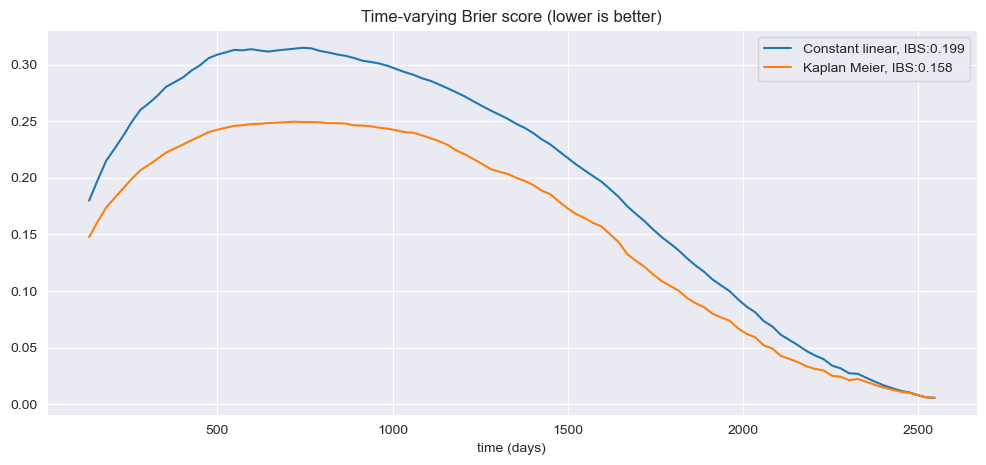

In [22]:
class SurvivalAnalysisEvaluator:
    
    def __init__(self, y_train, y_test, time_grid):
        self.model_data = {}
        self.y_train = as_sksurv_recarray(y_train)
        self.y_test = as_sksurv_recarray(y_test)
        self.time_grid = time_grid
        
    def add_model(self, model_name, survival_curves):
        _, brier_scores = brier_score(
            survival_train=self.y_train,
            survival_test=self.y_test,
            estimate=survival_curves,
            times=self.time_grid,
        )
        ibs = integrated_brier_score(
            survival_train=self.y_train,
            survival_test=self.y_test,
            estimate=survival_curves,
            times=self.time_grid,
        )
        c_index = compute_c_index(
            self.y_test["event"],
            self.y_test["duration"],
            survival_curves,
        )
        self.model_data[model_name] = {
            "brier_scores": brier_scores,
            "ibs": ibs,
            "c_index": c_index,
        }

    def metrics_table(self):
        return pd.DataFrame([
            {
                "Model": model_name,
                "IBS": info["ibs"],
                "C-index": info["c_index"],
            }
            for model_name, info in self.model_data.items()
        ])
        
    def plot(self, model_names=None):
        if model_names is None:
            model_names = list(self.model_data.keys())
        fig, ax = plt.subplots(figsize=(12, 5))
        self._plot_brier_scores(model_names, ax=ax)

    def _plot_brier_scores(self, model_names, ax):
        for model_name in model_names:
            info = self.model_data[model_name]
            ax.plot(
                self.time_grid,
                info["brier_scores"],
                label=f"{model_name}, IBS:{info['ibs']:.3f}");
        ax.set(
            title="Time-varying Brier score (lower is better)",
            xlabel="time (days)",
        )
        ax.legend()
        
    def __call__(self, model_name, survival_curves, model_names=None):
        self.add_model(model_name, survival_curves)
        self.plot(model_names=model_names)
        return self.metrics_table()

evaluator = SurvivalAnalysisEvaluator(y_train, y_test, time_grid)
evaluator.add_model("Constant linear", constant_linear_survival_curves)
evaluator.add_model("Kaplan Meier", y_pred_km_test)
evaluator.plot()
evaluator.metrics_table()

Next, we'll study how to fit survival models that make predictions that depend on the covariates $X$.

## IV. Predictive survival analysis

We now introduce some quantities which are going to be at the core of many survival analysis models.

The most important concept is the hazard rate $\lambda(t)$. This quantity represents the "speed of failure" or the probability that an event occurs in the next $dt$, given that it hasn't occured yet. This can be written as:

$$\begin{align}
\lambda(t) &=\lim_{dt\rightarrow 0}\frac{P(t \leq T < t + dt | P(T \geq t))}{dt} \\
&= \lim_{dt\rightarrow 0}\frac{P(t \leq T < t + dt)}{dtS(t)} \\
&= \frac{f(t)}{S(t)}
\end{align}
$$

where $f(t)$ represents the probability density. This quantity estimates the probability that an event occurs in the next $dt$, independently of this event having happened before. <br>
If we integrate $f(t)$, we found the cumulative incidence function (CIF) $F(t)=P(T < t)$, which is the opposite of the survival function $S(t)$:

$$F(t)=\int^\infty_0f(t)dt=1-S(t)$$

### IV.1 Cox Proportional Hazards

The Cox PH model is the most popular way of dealing with covariates $X$ in survival analysis. It computes a log linear regression on the target $Y = \min(T, C)$, and consists in a baseline term $\lambda_0(t)$ and a covariate term with weights $\beta$.
$$\lambda(t, x_i) = \lambda_0(t) \exp(x_i^\top \beta)$$

Note that only the baseline depends on the time $t$, but we can extend Cox PH to time-dependent covariate $x_i(t)$ and time-dependent weigths $\beta(t)$. We won't cover these extensions in this tutorial.

This methods is called ***proportional*** hazards, since for two different covariate vectors $x_i$ and $x_j$, their ratio is:
$$\frac{\lambda(t, x_i)}{\lambda(t, x_j)} = \frac{\lambda_0(t) e^{x_i^\top \beta}}{\lambda_0(t) e^{x_j^\top \beta}}=\frac{e^{x_i^\top \beta}}{e^{x_j^\top \beta}}$$

This ratio is not dependent on time, and therefore the hazards are proportional.

Let's run it on our truck-driver dataset using the implementation of `sksurv`. This models requires preprocessing of the categorical features using One-Hot encoding. Let's use the scikit-learn column-transformer to combine the various components of the model as a pipeline:

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis

transformer = make_column_transformer(
    (OneHotEncoder(), ["brand", "truck_model"]),
    remainder="passthrough",
)
cox_ph_pipeline = make_pipeline(
    transformer,
    CoxPHSurvivalAnalysis(alpha=1e-4)
)
cox_ph_pipeline.fit(X_train, as_sksurv_recarray(y_train))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['brand', 'truck_model'])])),
                ('coxphsurvivalanalysis', CoxPHSurvivalAnalysis(alpha=0.0001))])

Let's compute the predicted survival functions for each row of the test set `X_test` and plot the first 5 survival functions:

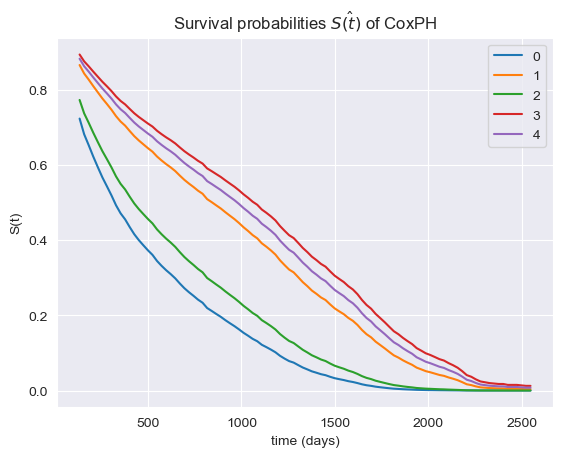

In [24]:
cox_ph_survival_funcs = cox_ph_pipeline.predict_survival_function(X_test)

fig, ax = plt.subplots()
for idx, cox_ph_survival_func in enumerate(cox_ph_survival_funcs[:5]):
    survival_probs = cox_ph_survival_func(time_grid)
    ax.plot(time_grid, survival_probs, label=idx)
ax.set(
    title="Survival probabilities $\hat{S(t)}$ of CoxPH",
    xlabel="time (days)",
    ylabel="S(t)",
)
plt.legend();

In [25]:
X_test.head(5).reset_index(drop=True)

driver_skill    brand truck_model  usage_rate
0      0.305925   Cheapz          C2    0.615741
1      0.521142   Cheapz          C2    0.332140
2      0.790874  Robusta          RA    0.770457
3      0.701073   Cheapz          C3    0.830584
4      0.698231   Cheapz          C2    0.441076

We see that predicted survival functions can vary significantly for different test samples.

Let's try to get some intuition about the features importance from the first 5 truck-driver pairs and their survival probabilities.

***Exercice***

Plot the feature importance $\beta$ of the model (stored under `_coef`) with their names from the `get_feature_names_out()` method of the transformer.

*Hint*: You can access an element of a pipeline as simply as `pipeline[idx]`.

In [26]:
cox_ph_pipeline  # the full pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['brand', 'truck_model'])])),
                ('coxphsurvivalanalysis', CoxPHSurvivalAnalysis(alpha=0.0001))])

In [27]:
cox_ph_pipeline[0]  # the first step of the pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['brand', 'truck_model'])])

In [28]:
cox_ph_pipeline[1]  # the second step of the pipeline

CoxPHSurvivalAnalysis(alpha=0.0001)

In [29]:
### Your code here




feature_names = []
weights = []



###

**Solution**

In [30]:
feature_names = cox_ph_pipeline[-2].get_feature_names_out()
feature_names.tolist()

['onehotencoder__brand_Cheapz',
 'onehotencoder__brand_Robusta',
 'onehotencoder__truck_model_C1',
 'onehotencoder__truck_model_C2',
 'onehotencoder__truck_model_C3',
 'onehotencoder__truck_model_RA',
 'onehotencoder__truck_model_RB',
 'remainder__driver_skill',
 'remainder__usage_rate']

In [31]:
weights = cox_ph_pipeline[-1].coef_
weights

array([ 0.02546287, -0.02546293,  0.44524027,  0.13810987, -0.55788727,
        0.57128222, -0.59674517, -1.74762739,  1.52790707])

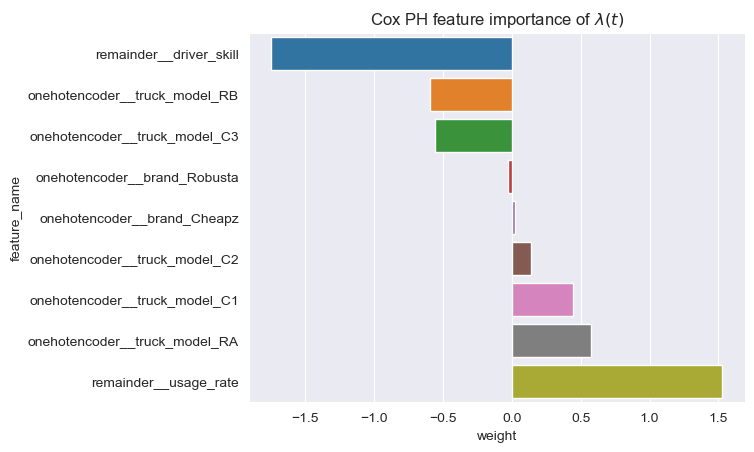

In [32]:
features = (
    pd.DataFrame(
        dict(
            feature_name=feature_names,
            weight=weights,
        )
    )
    .sort_values("weight")
)
ax = sns.barplot(features, y="feature_name", x="weight", orient="h")
ax.set_title("Cox PH feature importance of $\lambda(t)$");

Finally, we compute the Brier score for our model.

Model       IBS   C-index
0  Constant linear  0.198662  0.500000
1     Kaplan Meier  0.157704  0.500000
2           Cox PH  0.133074  0.690684

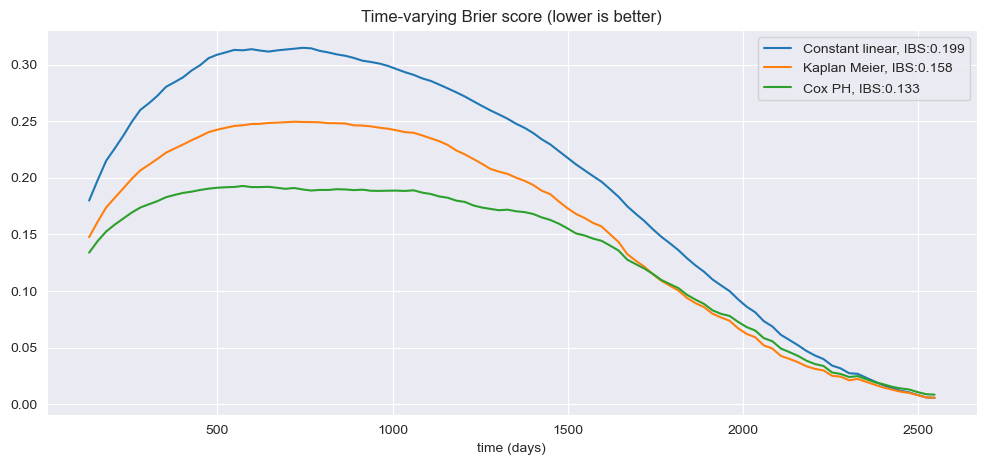

In [33]:
cox_survival_curves = np.vstack(
    [
        cox_ph_survival_func(time_grid)
        for cox_ph_survival_func in cox_ph_survival_funcs
    ]
)

evaluator("Cox PH", cox_survival_curves)

So the Cox Proportional Hazard model from scikit-survival fitted as a simple pipeline with one-hot encoded categorical variables and raw numerical variables seems already significantly better than our unconditional baseline.

**Exercise**

Let's define a more expressive polynomial feature engineering pipeline for a Cox PH model that:

- encodes categorical variables using the `OneHotEncoder` as previously;
- transforms numerical features with `SplineTransformer()` (using the default parameters);
- transforms the resulting of the encoded categorical variables and spline-transformed numerical variables using a degree 2 polynomial kernel approximation using the Nystroem method (e.g. `Nystroem(kernel="poly", degree=2, n_components=300)`)

In [34]:
X.columns

Index(['driver_skill', 'brand', 'truck_model', 'usage_rate'], dtype='object')

In [35]:
from sklearn.preprocessing import SplineTransformer
from sklearn.kernel_approximation import Nystroem

# TODO: write your pipeline here.


# step 1: define a column transformer to:
# - one-hot encode categorical columns
# - spline-transform numerical features

# step 2: define a Nystroem approximate degree 2 polynomial feature expansion

# step 3: assemble everything in a pipeline with a CoxPHSurvivalAnalysis
# model at the end.

# step 4: fit the pipeline on the training set.

# step 5: predict the survival functions for each row of the test set.

# step 6: compute the values of the survival function on the usual `time_grid`
# and store the result in an array named `poly_cox_ph_survival_curves`.

# Uncomment the following to evaluate your pipeline:

# evaluator("Polynomial Cox PH", poly_cox_ph_survival_curves)

Model       IBS   C-index
0    Constant linear  0.198662  0.500000
1       Kaplan Meier  0.157704  0.500000
2             Cox PH  0.133074  0.690684
3  Polynomial Cox PH  0.126165  0.698872

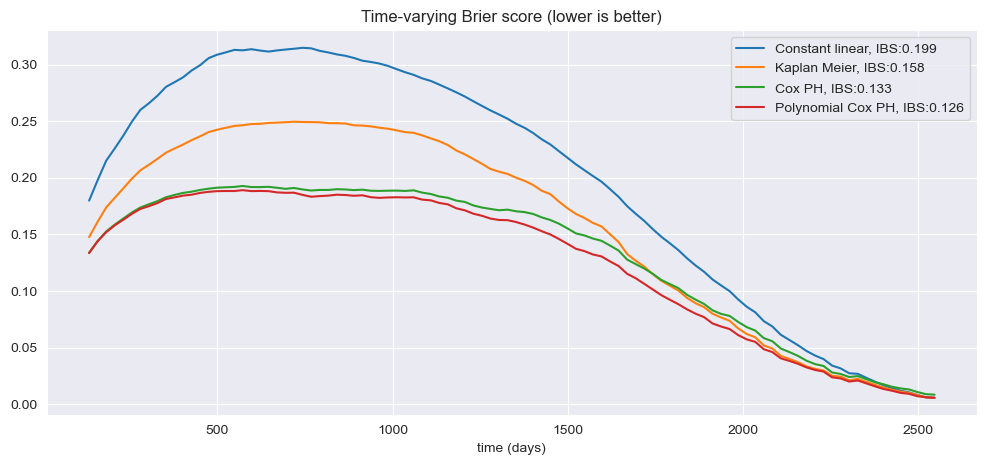

In [36]:
### Solution:

from sklearn.preprocessing import SplineTransformer
from sklearn.kernel_approximation import Nystroem


transformer = make_column_transformer(
    (OneHotEncoder(), ["brand", "truck_model"]),
    (SplineTransformer(), ["driver_skill", "usage_rate"]),
)
poly_cox_ph_pipeline = make_pipeline(
    transformer,
    Nystroem(kernel="poly", degree=2, n_components=300),
    CoxPHSurvivalAnalysis(alpha=1e-4)
)
poly_cox_ph_pipeline.fit(X_train, as_sksurv_recarray(y_train))
poly_cox_ph_survival_funcs = poly_cox_ph_pipeline.predict_survival_function(X_test)


poly_cox_ph_survival_curves = np.vstack(
    [
        poly_cox_ph_survival_func(time_grid)
        for poly_cox_ph_survival_func in poly_cox_ph_survival_funcs
    ]
)
evaluator("Polynomial Cox PH", poly_cox_ph_survival_curves)

### IV.2 Random Survival Forest

Random Survival Forests are non-parametric model that is potentially more expressive than Cox PH. In particular, if we expect that the shape of the time varying hazards are not the same for each individual, tree-based models such as RSF might perform better. In general they also require a large enough training set to avoid overfitting.

Note however that they are quite computational intensive and their training time can be prohibitive on very large dataset.

In [37]:
from sksurv.ensemble import RandomSurvivalForest

rsf = make_pipeline(
    transformer,
    RandomSurvivalForest(n_estimators=10, max_depth=8, n_jobs=-1),
)
rsf.fit(X_train, as_sksurv_recarray(y_train))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['brand', 'truck_model']),
                                                 ('splinetransformer',
                                                  SplineTransformer(),
                                                  ['driver_skill',
                                                   'usage_rate'])])),
                ('randomsurvivalforest',
                 RandomSurvivalForest(max_depth=8, n_estimators=10,
                                      n_jobs=-1))])

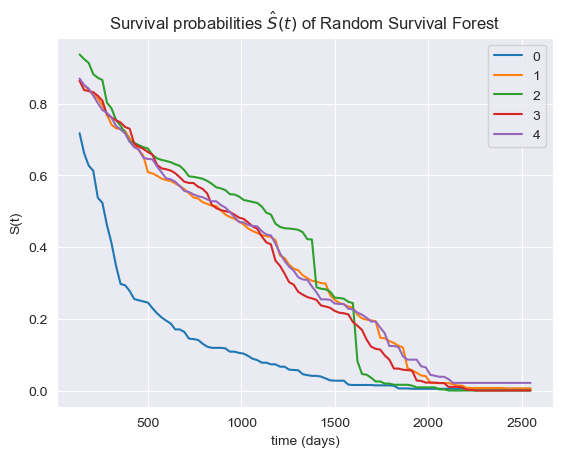

In [38]:
rsf_survival_funcs = rsf.predict_survival_function(X_test)

fig, ax = plt.subplots()
for idx, survival_func in enumerate(rsf_survival_funcs[:5]):
    survival_curve = survival_func(time_grid)
    ax.plot(time_grid, survival_curve, label=idx)
ax.set(
    title="Survival probabilities $\hat{S}(t)$ of Random Survival Forest",
    xlabel="time (days)",
    ylabel="S(t)",
)
plt.legend();

Indeed we observe that the shapes of the curves can vary more than for the Cox-PH model which is more constrained. Let's see if this flexibility makes it a better predictive model on aggregate on the test set:

Model       IBS   C-index
0         Constant linear  0.198662  0.500000
1            Kaplan Meier  0.157704  0.500000
2                  Cox PH  0.133074  0.690684
3       Polynomial Cox PH  0.126165  0.698872
4  Random Survival Forest  0.129386  0.651994

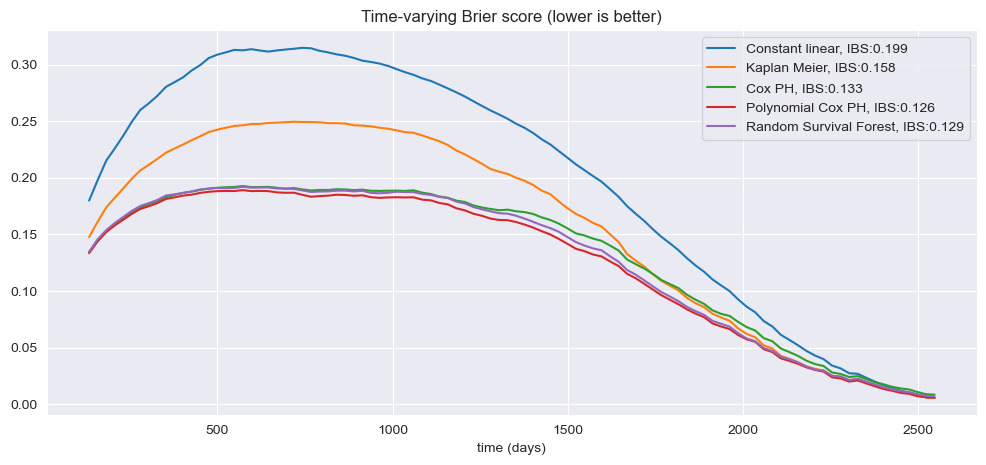

In [39]:
rsf_survival_curves = np.vstack(
    [func(time_grid) for func in rsf_survival_funcs]
)
evaluator("Random Survival Forest", rsf_survival_curves)

Unfortunately this does not seem to be able to significantly improve upon the Cox PH model as a ranking model.

### IV.3 GradientBoostedCIF

In [40]:
import sys; sys.path.append("..")
from models.gradient_boosted_cif import GradientBoostedCIF
from model_selection.wrappers import PipelineWrapper


gb_cif = make_pipeline(
    transformer,
    GradientBoostedCIF(n_iter=100, max_leaf_nodes=5, learning_rate=0.1),
)
gb_cif = PipelineWrapper(gb_cif)
gb_cif.fit(X_train, y_train, time_grid)

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 37.58it/s]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 108.37it/s]


Model       IBS   C-index
0         Constant linear  0.198662  0.500000
1            Kaplan Meier  0.157704  0.500000
2                  Cox PH  0.133074  0.690684
3       Polynomial Cox PH  0.126165  0.698872
4  Random Survival Forest  0.129386  0.651994
5   Gradient Boosting CIF  0.127799  0.689273

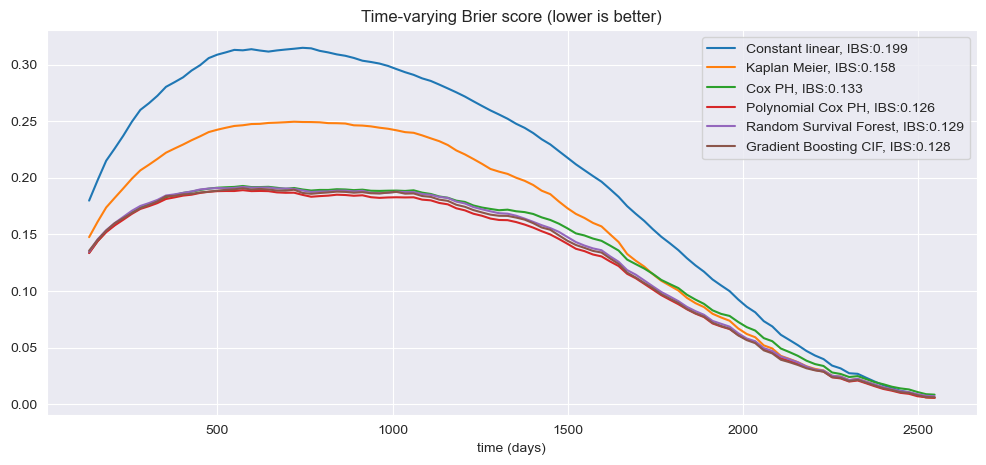

In [41]:
gbcif_survival_curves = gb_cif.predict_survival_function(X_test, time_grid)
evaluator("Gradient Boosting CIF", gbcif_survival_curves)

This model is often better than Random Survival Forest but significantly faster to train and requires few feature engineering than a Cox PH model.

### IV.4 Comparing our models to the optimal survival curves

Since the dataset is synthetic, we can access the underlying hazard function for each row of `X_test`:

In [42]:
with np.load("truck_failure_10k_hazards.npz") as f:
    all_theoretical_hazards = f["truck_failure_10k_hazards"]
all_theoretical_hazards.shape

(3, 10000, 3650)

The first axis correspond to the 3 types of failures of this dataset (that will be covered in the next section). For now let's collapse them all together an consider the "any event" hazard functions:

In [43]:
any_event_hazards = all_theoretical_hazards.sum(axis=0)
any_event_hazards.shape

(10000, 3650)

We can then extra the test records:

In [44]:
any_event_hazards_test = any_event_hazards[idx_test]
any_event_hazards_test.shape

(4999, 3650)

and finally, do a numerical integration over the last dimension (using `cumsum(axis=-1)`) and take the exponential of the negative cumulated hazards to recover the theoretical survival curves for each sample of the test set:

In [45]:
theoretical_survival_curves = np.exp(-any_event_hazards_test.cumsum(axis=-1))
theoretical_survival_curves.shape

(4999, 3650)

Finally, we can evaluate the performance metrics (IBS and C-index) of the theoretical curves on the same test events and `time_grid` to be able to see how far our best predictive survival analysis models are from the optimal model:

Model       IBS   C-index
0          Constant linear  0.198662  0.500000
1             Kaplan Meier  0.157704  0.500000
2                   Cox PH  0.133074  0.690684
3        Polynomial Cox PH  0.126165  0.698872
4   Random Survival Forest  0.129386  0.651994
5    Gradient Boosting CIF  0.127799  0.689273
6  Data generative process  0.123745  0.690055

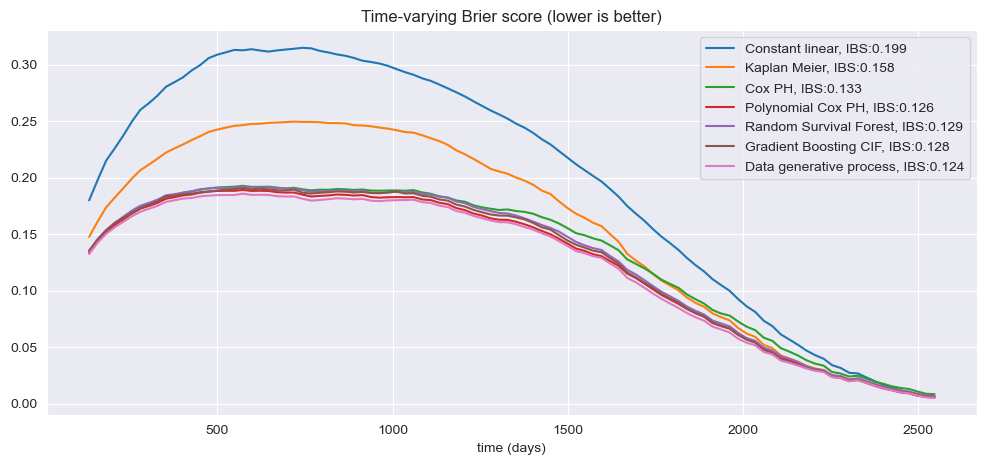

In [46]:
n_total_days = any_event_hazards.shape[-1]
original_time_range = np.linspace(0, n_total_days, n_total_days)

theoretical_survival_curves = np.asarray([
    interp1d(
        original_time_range,
        surv_curve,
        kind="previous",
        bounds_error=False,
        fill_value="extrapolate",
    )(time_grid) for surv_curve in theoretical_survival_curves
])

evaluator("Data generative process", theoretical_survival_curves)

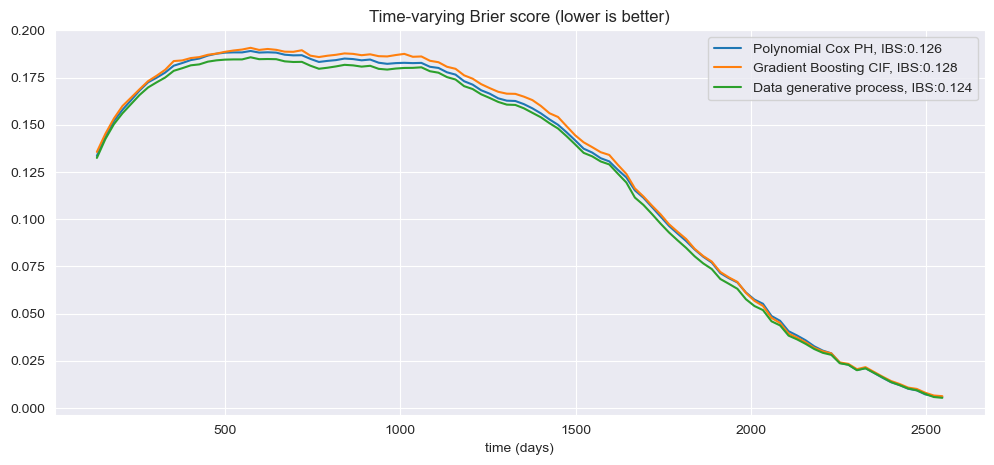

In [47]:
evaluator.plot(model_names=["Polynomial Cox PH", "Gradient Boosting CIF", "Data generative process"])

We observe that our best models are quite close to the theoretical optimum but there is still some slight margin for improvement. It's possible that re-training the same model pipelines with a larger number of training sample could help close that gap.

Note that the IBS and C-index values of the theoretical survival curves are far from 0.0 and 1.0 respectively: this is expected because not all the variations of the target `y` can be explained by the values of the columns of `X`: there is still a large irreducible amount of unpredictable "noise" in this data generating process.

Other survival models:

TODO: mention and link to XGBSE, DeepHit, SurvTrace...

Also possible to improve the Cox PH model with non-linear feature engineering: SplineTransformer for numerical features then feature interaction via a Nystroem kernel approximation of degree 2 or 3 polynomial expansion.

## V. Unconditional competing risks modeling with Aalen-Johanson

So far, we've been dealing with a single kind of risk: any accident. What if we have different types of accident? This is the point of competing risks modeling. It aims at modeling the probability of incidence for different events, where these probabilities interfer with each other. A truck that had an accident is withdrawn from the fleet, and therefore can't experienced any other ones.

For any event $k \in [1, K]$, the cumulative incidence function of the event $k$ becomes:

$$CIF_k = P(T < t, \mathrm{event}=k)$$

Aalen-Johanson estimates the CIF for multi-event $k$, by computing the global (any event) survival probabilities and the cause-specific hazards.

<details><summary>Mathematical formulation</summary>
    
<br>
We first compute the cause-specific hazards $\lambda_k$, by simply counting for each individual duration $t_i$ the number of individuals that have experienced the event $k$ at $t_i$ ($d_{i,k}$), and the number of people still at risk at $t_i$ ($n_i$).

$$
\hat{\lambda}_k(t_i)=\frac{d_{k,i}}{n_i}
$$

Then, we compute the survival probability any event with Kaplan Meier any event, where we can reused the cause-specific hazards.
    
$$
\hat{S}(t)=\prod_{i:t_i\leq t} (1 - \frac{d_i}{n_i})=\prod_{i:t_i\leq t} (1 - \sum_k\hat{\lambda}_{k}(t_i))
$$

Finally, we compute the CIF of event $k$ as the sum of the cause-specific hazards, weighted by the survival probabilities.

$$\hat{F}_k(t)=\sum_{i:t_i\leq t} \hat{\lambda}_k(t_i) \hat{S}(t_{i-1})$$
    
    
</details>

Let's load our dataset another time. Notice that we have 3 types of event (plus the censoring 0). In the previous section, we only considered binary "any events" by applying `event > 0` to our event column.

In [48]:
truck_failure_competing_events = pd.read_parquet("truck_failure_10k_competing_risks.parquet")
truck_failure_competing_events

event     duration
0         3   980.394661
1         2  1207.870100
2         0   125.000000
3         1    96.839004
4         2    88.077852
...     ...          ...
9995      2     0.435731
9996      2   492.591211
9997      1   847.951259
9998      2    25.551167
9999      0    23.000000

[10000 rows x 2 columns]

Let's use lifelines to estimate the ${CIF_k}$ using Aalen-Johanson. We need to indicate which event to fit on, so we'll iteratively fit the model on all events.

Fitting Aalen-Johansen for event 1...
Fitting Aalen-Johansen for event 2...
Fitting Aalen-Johansen for event 3...


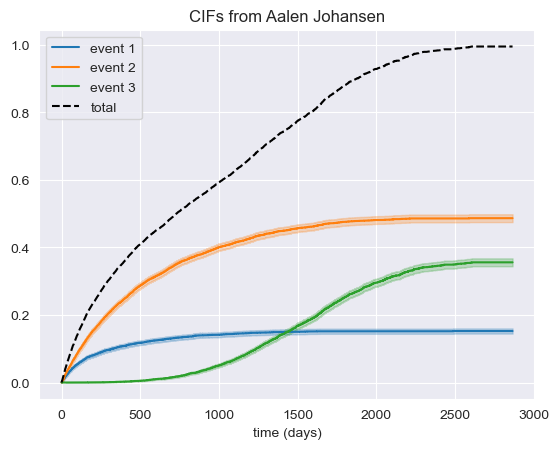

In [49]:
from lifelines import AalenJohansenFitter

fig, ax = plt.subplots()

total_cif = None
competing_risk_ids = sorted(
    truck_failure_competing_events.query("event > 0")["event"].unique()
)
for event in competing_risk_ids:
    print(f"Fitting Aalen-Johansen for event {event}...")
    ajf = AalenJohansenFitter(calculate_variance=True)
    ajf.fit(
        truck_failure_competing_events["duration"],
        truck_failure_competing_events["event"],
        event_of_interest=event
    )
    ajf.plot(ax=ax, label=f"event {event}")
    cif_df = ajf.cumulative_density_
    cif_times = cif_df.index
    if total_cif is None:
        total_cif = cif_df[cif_df.columns[0]].values
    else:
        total_cif += cif_df[cif_df.columns[0]].values

ax.plot(cif_times, total_cif, label="total", linestyle="--", color="black")
ax.set(title="CIFs from Aalen Johansen", xlabel="time (days)")
plt.legend();

This un-conditional model helps us identify 3 types of events, having momentum at different times.

## VI. Cumulative incidence function (CIF) using our GradientBoostedCIF

We can now try to estimate the conditional cumulative incidence function using our GradientBoostedCIF.

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 277.98it/s]


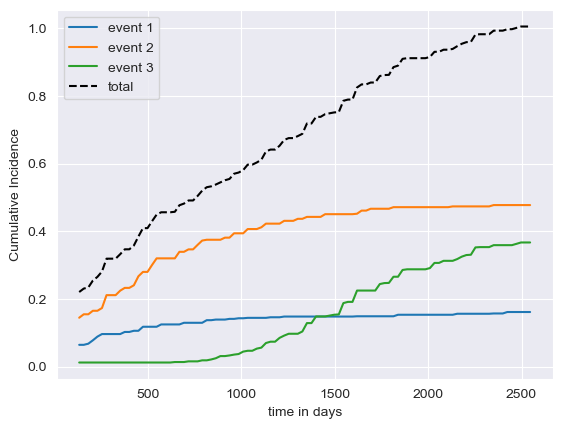

In [50]:
y_cr = truck_failure_competing_events
X_train, X_test, y_cr_train, y_cr_test, idx_train, idx_test = train_test_split_within(
    X, y_cr, np.arange(X.shape[0]), random_state=0
)

time_grid = make_test_time_grid(y_test["duration"])
total_mean_cif = np.zeros(time_grid.shape[0])

fig, ax = plt.subplots()
for event in competing_risk_ids:    
    gb_cif = make_pipeline(
        transformer,
        GradientBoostedCIF(event_of_interest=event, max_leaf_nodes=5, n_iter=50, learning_rate=0.1),
    )
    gb_cif = PipelineWrapper(gb_cif)
    
    gb_cif.fit(X_train, y_cr_train, time_grid)
    cif_matrix_k = gb_cif.predict_cumulative_incidence(X_test, time_grid)
    
    mean_cif_k = cif_matrix_k.mean(axis=0)
    total_mean_cif += mean_cif_k
    ax.plot(time_grid, mean_cif_k, label=f"event {event}")

ax.plot(time_grid, total_mean_cif, label="total", linestyle="--", color="black")
ax.set(xlabel="time in days", ylabel="Cumulative Incidence")
plt.legend();

In the second section of this tutorial, we'll study our GradientBoostedCIF in more depth by understanding how to find the median survival probability and compute its feature importance.